<a href="https://colab.research.google.com/github/zahidparviz/waste_classificatio_cnn/blob/main/Waste_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Part 1: Import Libraries and Set Paths
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils import plot_model
from glob import glob
import warnings
warnings.filterwarnings('ignore')
import os
from collections import Counter
from keras.applications import VGG16

In [ ]:
# Part 2: Importing additional useful libraries.

# Part 2: More Libraries and Model Definition
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils import plot_model
from glob import glob
import os

# Path to the extracted DATASET directory
extracted_path = '/content/DATASET/'

# Update the paths
train_path = os.path.join(extracted_path, 'TRAIN')
test_path = os.path.join(extracted_path, 'TEST')

# Display the updated paths
print(f"Updated train_path: {train_path}")
print(f"Updated test_path: {test_path}")


Updated train_path: /content/DATASET/TRAIN
Updated test_path: /content/DATASET/TEST


In [ ]:
import zipfile
import os

# Define the path to the zip file
zip_file_path = "/content/DATASET.zip"

# Open the zip file
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    # Extract the contents of the zip file to the same directory
    zip_ref.extractall(os.path.dirname(zip_file_path))


In [ ]:
# Part 3: Load and Preprocess Data
x_data = []
y_data = []

for category in glob(train_path + '/*'):
    for file in tqdm(glob(category + '/*')):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])

data = pd.DataFrame({'image': x_data, 'label': y_data})
data.shape

100%|██████████| 12565/12565 [00:10<00:00, 1165.45it/s]


(22564, 2)

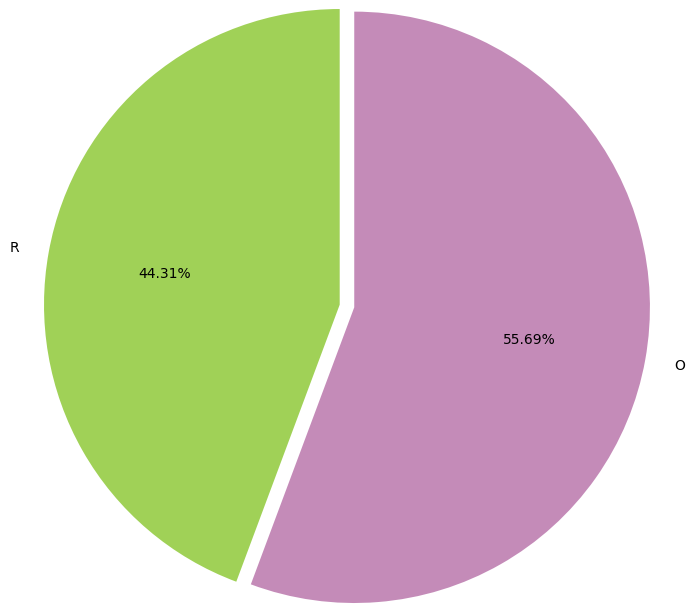

Number Of Class:  2


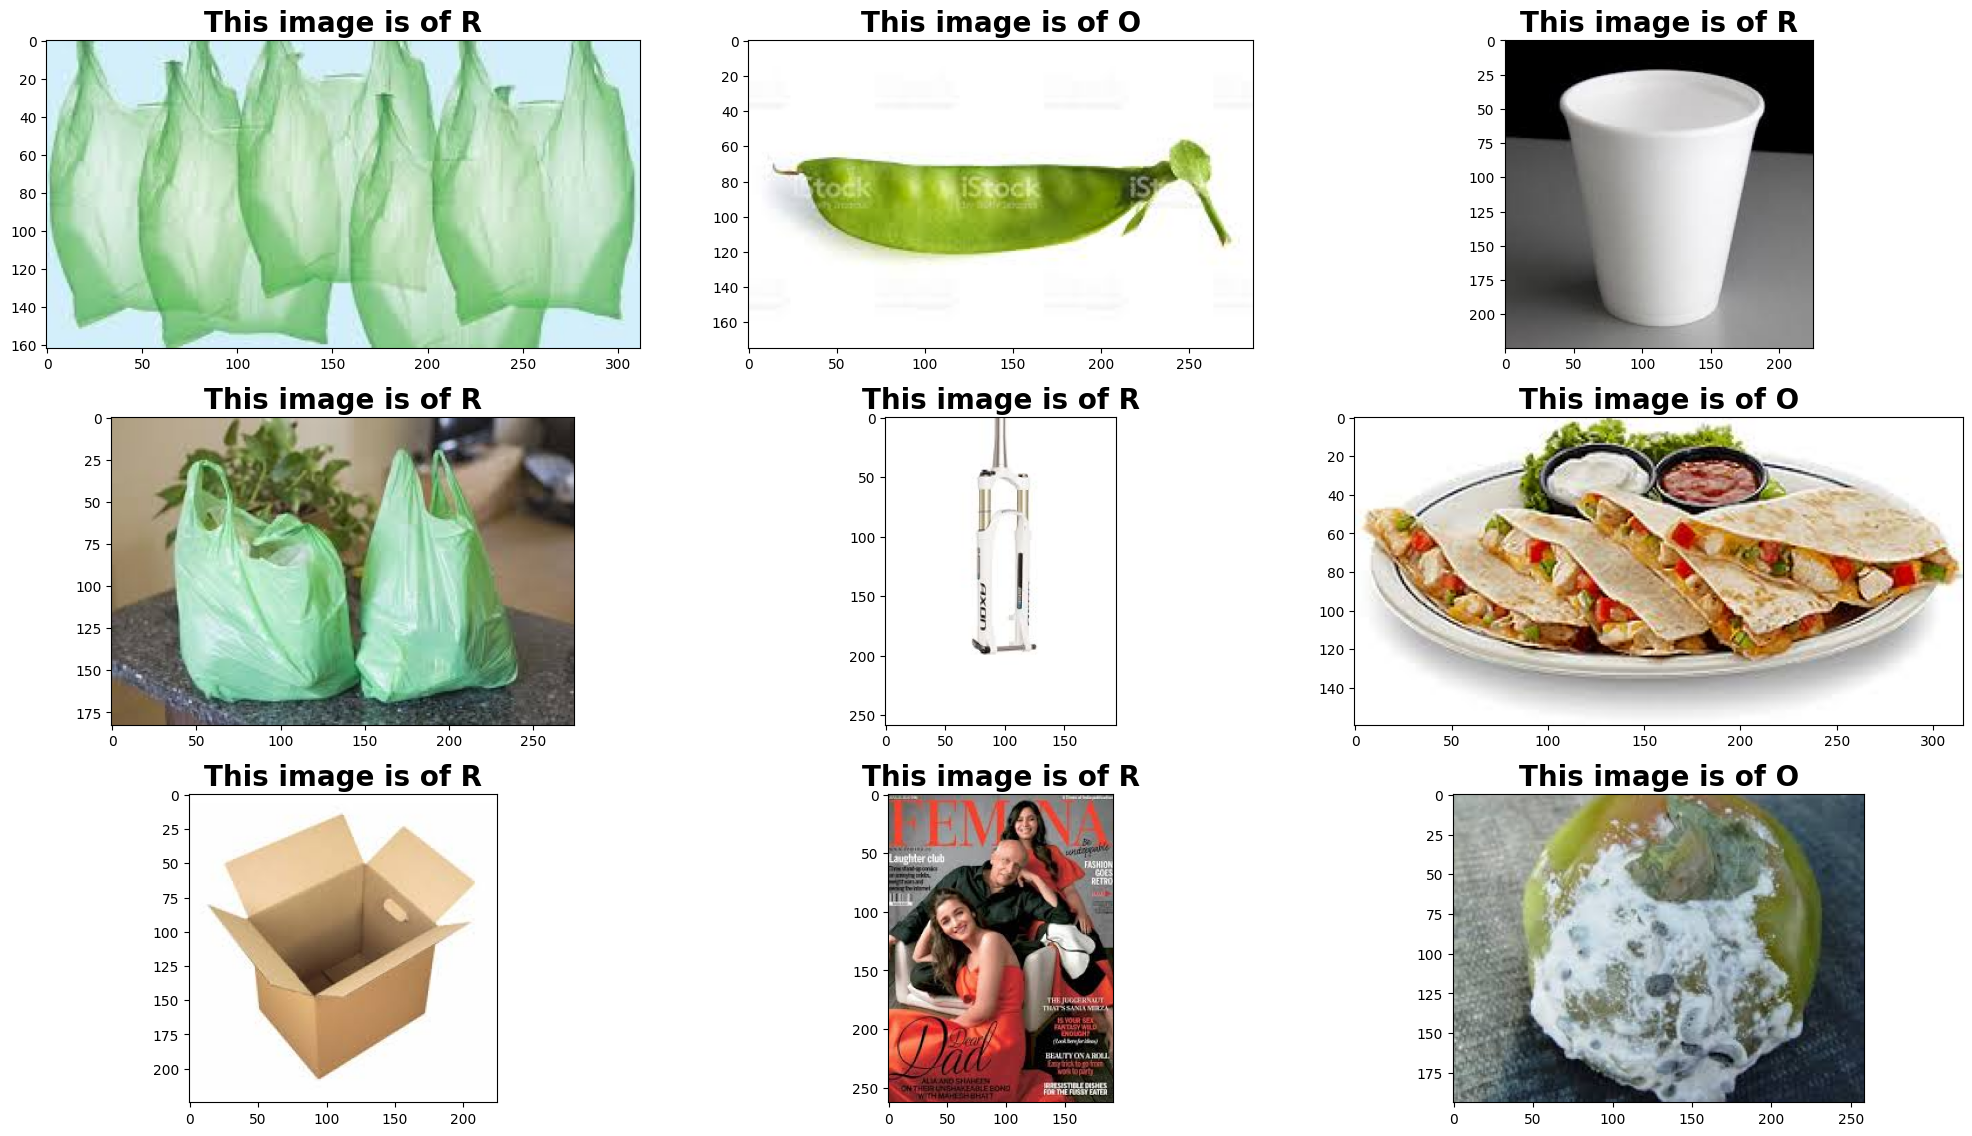

In [ ]:
# Part 4: Data Exploration and Visualization
Counter(y_data)

colors = ['#a0d157', '#c48bb8']
plt.pie(Counter(y_data).values(), startangle=90, explode=[0.05, 0.05], autopct='%0.2f%%',
        labels=Counter(y_data).keys(), colors=colors, radius=2)
plt.show()

plt.figure(figsize=(20, 15))
for i in range(9):
    plt.subplot(4, 3, (i % 12) + 1)
    index = np.random.randint(len(data))
    plt.title('This image is of {0}'.format(data.label[index]), fontdict={'size': 20, 'weight': 'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ", numberOfClass)


In [ ]:
# Part 5: CNN Model Definition
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass, activation='sigmoid'))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

batch_size = 32  # Adjust based on GPU memory


In [ ]:
# Part 6: Plot Model and Data Generators
plot_model(model)

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Note: Make sure to set `shuffle=False` to avoid issues with data order during training
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=batch_size,
        color_mode="rgb",
        class_mode="categorical",
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=batch_size,
        color_mode="rgb",
        class_mode="categorical",
        shuffle=False)


Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
# Part 7: Transfer Learning with VGG16 Base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(
    train_generator,
    epochs=10,  # Experiment with the number of epochs
    validation_data=test_generator,
    batch_size=batch_size,
    # Other parameters as needed
)

# Save the trained model
model.save('/content/waste_classifier_model.h5')

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
706/706 [==============================] - 128s 166ms/step - loss: 0.6839 - accuracy: 0.7573 - val_loss: 0.4018 - val_accuracy: 0.8492
Epoch 2/10
706/706 [==============================] - 105s 148ms/step - loss: 0.3880 - accuracy: 0.8128 - val_loss: 0.3582 - val_accuracy: 0.8727
Epoch 3/10
706/706 [==============================] - 105s 149ms/step - loss: 0.3440 - accuracy: 0.8339 - val_loss: 0.4577 - val_accuracy: 0.8313
Epoch 4/10
706/706 [==============================] - 104s 148ms/step - loss: 0.3289 - accuracy: 0.8456 - val_loss: 0.3773 - val_accuracy: 0.8536
Epoch 5/10
706/706 [==============================] - 105s 149ms/step - loss: 0.3048 - accuracy: 0.8541 - val_loss: 0.3226 - val_accuracy: 0.8834
Epoch 6/10
706/706 [==============================] - 105s 148ms/step - loss: 0.2838 - accuracy: 0.8623 - val_loss: 0.3095 - val_accuracy: 0.8814
Epoch 7/10
706/706 [==============================] - 104s 

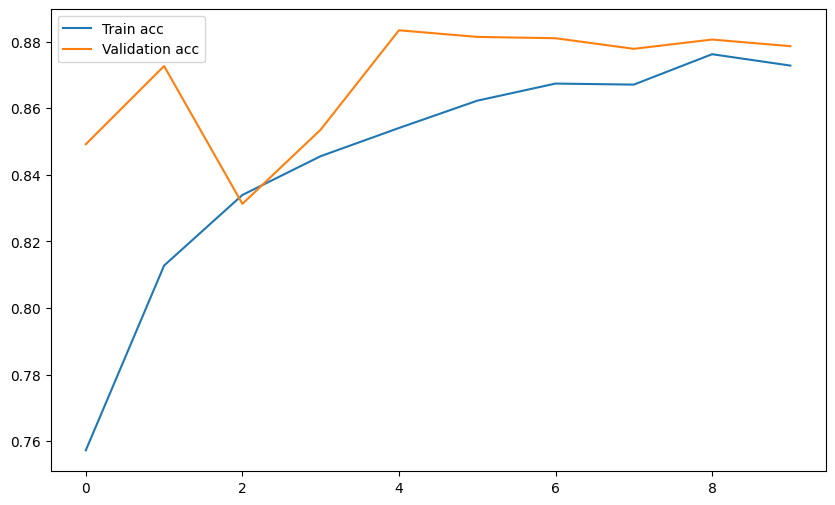

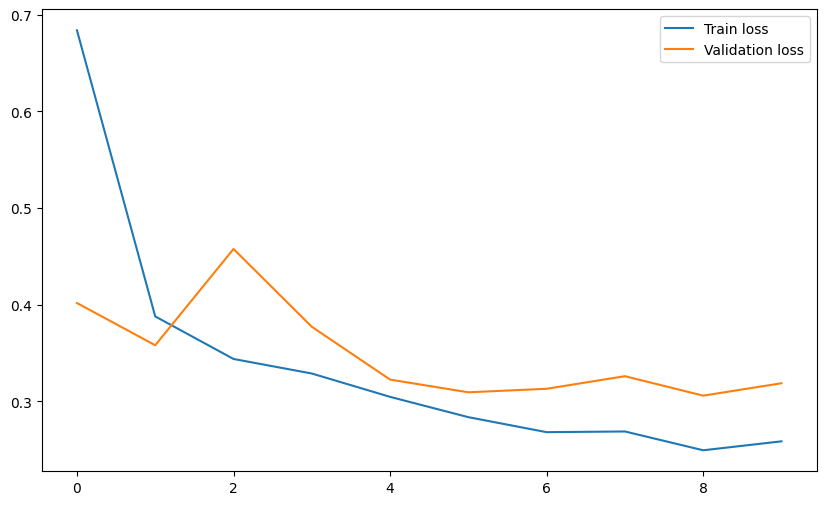

In [ ]:
# Part 8: Model Evaluation and Visualization
plt.figure(figsize=[10, 6])
plt.plot(hist.history["accuracy"], label="Train acc")
plt.plot(hist.history["val_accuracy"], label="Validation acc")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'], label="Train loss")
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.legend()
plt.show()

1/1 [==============================] - 0s 348ms/step


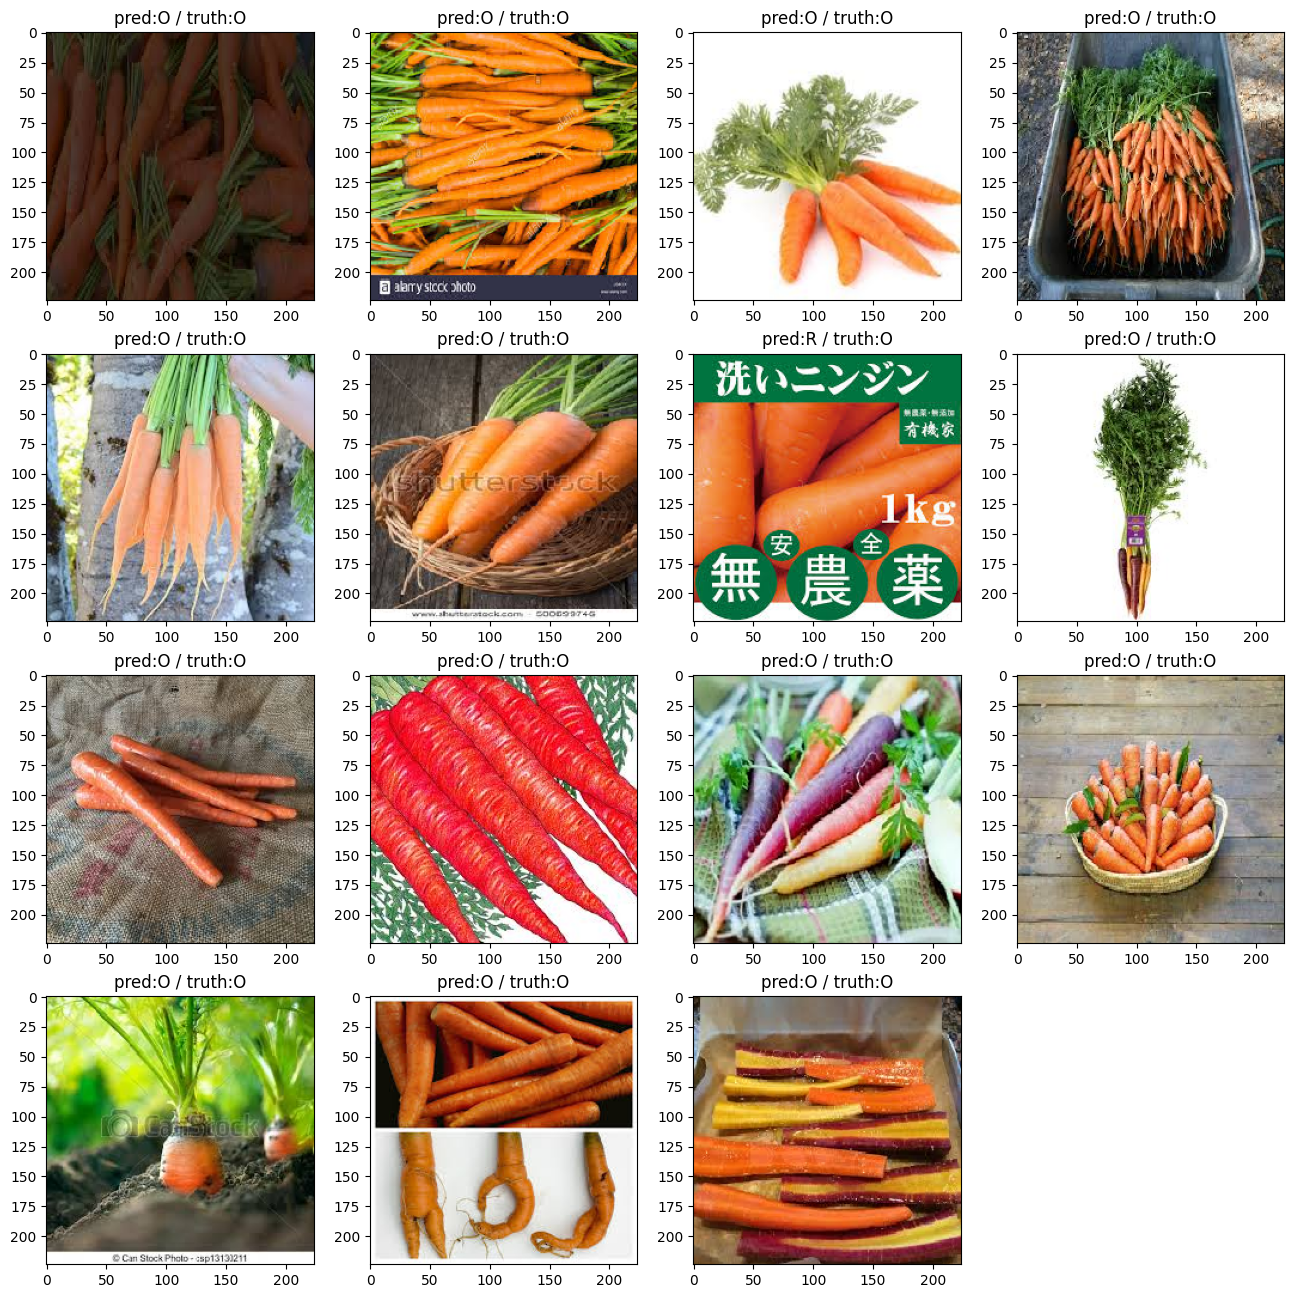

In [ ]:
# Part 9: Test Model on Sample Images
test_x, test_y = test_generator.__getitem__(1)

labels = (test_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(15):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])

In [ ]:
import tensorflow as tf

# Load the saved .h5 model
h5_model_path = '/content/waste_classifier_model.h5'
loaded_model = tf.keras.models.load_model(h5_model_path)

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
tflite_model_path = '/content/waste_classifier_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f'TensorFlow Lite model saved at: {tflite_model_path}')


TensorFlow Lite model saved at: /content/waste_classifier_model.tflite
